In [70]:
 
ngram_length = 1
dstype = 'stress' 
mname = 'debertaV3'

In [71]:
from colorama import Fore, Style

import os

In [72]:
path = f"/home/bhairavi/om/om3/{dstype}/{ngram_length}grams_{mname}/"
os.makedirs(path, exist_ok=True)

print("Directory created or already exists.")
 

file_path = path + f'{dstype}_{ngram_length}keys.csv' 
print(Fore.YELLOW,"csv_filePATH--->",file_path)


filepath_full = path + f'{dstype}_{ngram_length}top5.csv' 
print(Fore.YELLOW,"QUE_filePATH--->",filepath_full)
 
 
 
modelpath = f"/home/bhairavi/om/om5/{dstype}/{mname}_{dstype}"

 

print(Fore.YELLOW,'modelPATH--->',modelpath)
 


Directory created or already exists.
 csv_filePATH---> /home/bhairavi/om/om3/stress/1grams_debertaV3/stress_1keys.csv
 QUE_filePATH---> /home/bhairavi/om/om3/stress/1grams_debertaV3/stress_1top5.csv
 modelPATH---> /home/bhairavi/om/om5/stress/debertaV3_stress


In [73]:

 
 
import torch  

torch.cuda.empty_cache()  
import pandas as pd
from datasets import Dataset, DatasetDict, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BertForSequenceClassification, BertTokenizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
 


# %%
from collections import defaultdict
import string
 
import torch.nn.functional as F
from nltk.util import ngrams

import numpy as np  
  


Maximum token length: 257
Next maximum token length: 185
Average token length: 94.10


Map: 100%|██████████| 142/142 [00:00<00:00, 3071.40 examples/s]


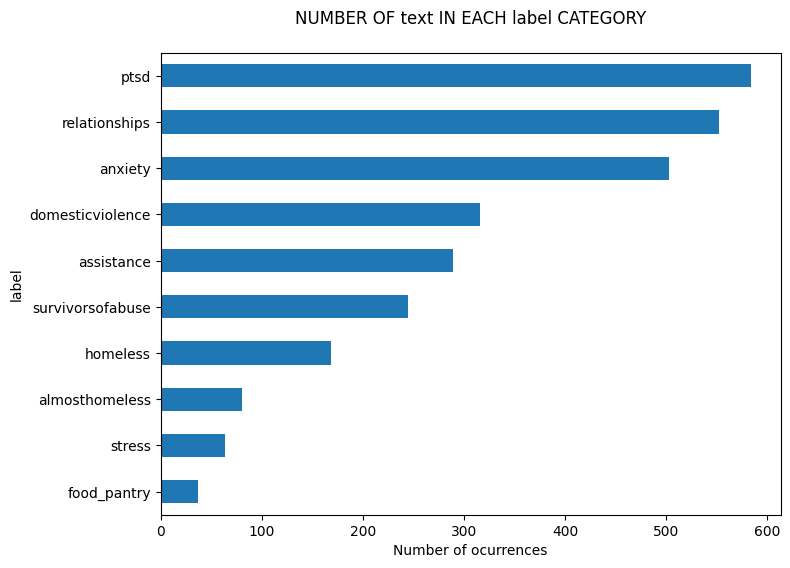

In [74]:

# %%
df = pd.read_csv('/home/bhairavi/om/om4/stress/Stress.csv')




# %%

# %%

# %%
df.sample(5)


# %%


# %%
df['label'] = df['subreddit']

# %%


# %%

# %%
from sklearn.preprocessing import LabelEncoder

# %%
le = LabelEncoder()
df['target'] = le.fit_transform(df['label'])

# %%



# %%

# %%
fig = plt.figure(figsize=(8,6)) 
df.groupby('label').text.count().sort_values().plot.barh(
    ylim=0,   title= 'NUMBER OF text IN EACH label CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);


# %%


# %%

# %%
numlabel = df['target'].nunique()
numlabel


# %%
df.columns

# %%
numlabel = df['target'].nunique()
numlabel


# %%
df['text'] = df['text'].apply(lambda x: x[:512])

# %%
from transformers import AutoTokenizer, AutoModelForSequenceClassification

device = "cuda"  # the device to load the model onto

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(modelpath)
model = AutoModelForSequenceClassification.from_pretrained(modelpath, num_labels=numlabel)

# Move the model to the specified device
model.to(device)

# %%
df['token_length'] = df['text'].apply(lambda x: len(tokenizer.tokenize(x)))

# Calculate the maximum token length
max_length = df['token_length'].max()

# Calculate the next maximum token length
next_max_token_length = df['token_length'].nlargest(2).iloc[1]

# Calculate the average token length
average_token_length = df['token_length'].mean()

# Display the results
print(f"Maximum token length: {max_length}")
print(f"Next maximum token length: {next_max_token_length}")
print(f"Average token length: {average_token_length:.2f}")

# %%

# %%
from sklearn.model_selection import StratifiedShuffleSplit

# Splitting off the test set with 5% of the data
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=42)  # 5% for test
for train_val_idx, test_idx in sss.split(df, df['target']):
    train_val_df = df.iloc[train_val_idx]
    test_df = df.iloc[test_idx]

# Further split train_val_df into train and validation sets with validation set being 15.79% of the remaining data
# (which is equivalent to 15% of the original dataset size)
sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)  # ~15.79% of remaining data
for train_idx, val_idx in sss_val.split(train_val_df, train_val_df['target']):
    train_df = train_val_df.iloc[train_idx]
    val_df = train_val_df.iloc[val_idx]
 

def tokenize_and_format(examples):
    # Tokenize the texts
    tokenized_inputs = tokenizer(examples['text'], padding="max_length", truncation=True, max_length=max_length)
    tokenized_inputs['label'] = list(map(int, examples['target']))
    return tokenized_inputs

# Convert pandas DataFrame to Hugging Face's Dataset
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(val_df) 
test_dataset = Dataset.from_pandas(test_df)

# Map the tokenization function across the datasets
train_dataset = train_dataset.map(tokenize_and_format, batched=True,batch_size=16)
eval_dataset = eval_dataset.map(tokenize_and_format, batched=True,batch_size=16) 
test_dataset = test_dataset.map(tokenize_and_format, batched=True,batch_size=16)






In [75]:


# %%


# %%
from sklearn.metrics import f1_score, precision_score, recall_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    return {
        'eval_f1': f1,
        'eval_precision': precision,
        'eval_recall': recall,
    }

 

 
 

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # Use 'epoch' to evaluate at the end of each epoch
    save_strategy="epoch",  # Also use 'epoch' to save at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,  # Load the best model at the end of training based on metric
    metric_for_best_model='f1',  # Define the metric for evaluating the best model
    logging_dir='./logs',
    logging_steps=10,
    report_to=[] 
)


 

trainer = Trainer(
    model=model,
    args=training_args ,  # Here you will need to make sure that the Trainer is set up correctly
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)

 




/home/bhairavi/om/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [76]:

 
io=   pd.DataFrame(eval_dataset)
 
batch_size = 4

# Convert your DataFrame to a list of texts
texts = io['text'].tolist()

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the specified device
model = model.to(device)

# Set the model to evaluation mode
model.eval()

# Disable gradient calculations for efficiency
with torch.no_grad():
    # Initialize lists to store predictions
    all_predictions = []
    
    # Process data in batches
    for start in range(0, len(texts), batch_size):
        end = start + batch_size
        batch_texts = texts[start:end]
        
        # Tokenize the batch
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
        
        # Move inputs to the same device as model
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Get predictions
        outputs = model(**inputs)
        # Apply softmax to get probabilities from the logits
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
        # Get the predicted class indices
        predicted_indices = torch.argmax(probabilities, dim=1)
        
        # Ensure the indices are back on CPU for DataFrame operations
        predicted_indices = predicted_indices.cpu()
        
        # Convert indices to actual labels if labels are strings
        if hasattr(tokenizer, 'get_labels') and callable(tokenizer.get_labels):
            predicted_labels = [tokenizer.get_labels()[idx] for idx in predicted_indices]
        else:
            predicted_labels = predicted_indices.tolist()
        
        # Append batch predictions to the list
        all_predictions.extend(predicted_labels)

# Add predictions to DataFrame
io['predicted_label'] = all_predictions
 


In [77]:
 

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# %%
top_n = 5
 
 
 
     


In [78]:
     


io[f'significant_{ngram_length}grams'] = None
io[f'{ngram_length}gram_weights'] = None 

def occlusion(text, model, tokenizer, label, ngram_length, device):
    """
    Perform occlusion on the text and return n-gram importances based on the specified n-gram length.
    """
    inputs = tokenizer(text, return_tensors='pt').to(device)
    original_logits = model(**inputs).logits
    original_probs = F.softmax(original_logits, dim=-1)
    original_prediction = original_probs[0][label].item()
    
    ngram_importances = defaultdict(float)
    words = text.split()
    ngrams_list = list(ngrams(words, ngram_length))
    
    for ngram in ngrams_list:
        occluded_text = " ".join([word if word not in ngram else "[OCCLUDED]" for word in words])
        occluded_inputs = tokenizer(occluded_text, return_tensors='pt').to(device)
        occluded_logits = model(**occluded_inputs).logits
        occluded_probs = F.softmax(occluded_logits, dim=-1)
        occluded_prediction = occluded_probs[0][label].item()
        
        ngram_importances[" ".join(ngram)] = original_prediction - occluded_prediction
        
    return ngram_importances

def aggregate_and_filter_positive_attributions(ngram_attributions, threshold=0):
    significant_ngrams = {
        ngram: value for ngram, value in ngram_attributions.items()
        if value > threshold
    }
    return significant_ngrams

def select_top_ngrams(ngram_importances, top_n=top_n):
    sorted_ngrams = sorted(ngram_importances.items(), key=lambda item: item[1], reverse=True)
    top_ngrams = sorted_ngrams[:top_n]
    return top_ngrams

# Assuming 'io' DataFrame exists and is properly formatted
for index, row in io.iterrows():
    if row['target'] == row['predicted_label']:  # Only proceed if prediction matches the label

        ngram_attributions = occlusion(row['text'], model, tokenizer, row['label'], ngram_length, device)
        positive_attributions = aggregate_and_filter_positive_attributions(ngram_attributions)
        top_ngrams = select_top_ngrams(positive_attributions, top_n=top_n)  # Ensure top_n is appropriately set
        
        # Store significant n-grams
        io.at[index, f'significant_{ngram_length}grams'] = [ngram for ngram, _ in top_ngrams]  # Rename this column to 'significant_ngrams'
        # Store weights
        io.at[index, f'{ngram_length}gram_weights'] = [weight for _, weight in top_ngrams]  # Rename this column to 'ngram_weights'


In [79]:

io.to_csv(filepath_full,index= False)

io[0:4]

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,target,token_length,__index_level_0__,input_ids,token_type_ids,attention_mask,predicted_label,significant_1grams,1gram_weights
0,homeless,766a8q,"(0, 5)","So I have a csf leak. It isn't diagnosed, but ...",5,0.600000,1507915266,5,105,1702,"[1, 471, 273, 286, 266, 2285, 39106, 9082, 260...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,None,None
1,ptsd,9xh5gt,"(30, 35)",My brother adopted me and enrolled me in the s...,6,1.000000,1542329082,6,98,1951,"[1, 573, 2387, 4347, 351, 263, 9047, 351, 267,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3,None,None
2,anxiety,9erk04,"(17, 22)","I really don’t know what to do about this, and...",1,0.833333,1536616850,1,90,26,"[1, 273, 431, 418, 276, 297, 391, 339, 264, 33...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",6,None,None
3,anxiety,934c5o,"[0, 5]","I began experiencing ""anxiety attacks"" around ...",1,1.000000,1532959562,1,117,1173,"[1, 273, 1196, 5252, 307, 61137, 3096, 309, 44...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,"[""anxiety, weeks, I, began, and]","[0.9946742465253919, 0.0001862645149230957, 0...."


In [80]:
 
io[f'significant_{ngram_length}grams'][0]
 
 


In [81]:


# %%

 
io['text'][0], io[f'significant_{ngram_length}grams'][0]



("So I have a csf leak. It isn't diagnosed, but being that its pretty much the only thing(I don't have any heart issues) that causes orthostatic headaches and and the other problems im having, its probably a csf leak. If I stand for more than 10 minutes or so after I wake up I develope a horrible headache that feels like its pressing downwards, and I basically become retarded. Like I cant even walk straight. I think my vision is starting to be affected too.",
 None)

In [82]:

# %%

# %%
io['label'] = le.inverse_transform(io['target'])

 


In [83]:


# %%
io= io.dropna()

# %%


In [84]:
# label_to_words = io.groupby('label')['significant_words'].apply(lambda words: set().union(*words)).to_dict()
label_to_words = io.groupby('label')[f'significant_{ngram_length}grams'].apply(lambda words: set().union(*words)).to_dict()
# label_to_words = io.groupby('label')['significant_5grams'].apply(lambda words: set().union(*words)).to_dict()
 
print(label_to_words)



{'almosthomeless': {'ex', 'My', 'to', 'problems', 'me', 'I', 'shelter', 'with', 'kids', 'place.', 'What', 'up.', 'own.', 'ones'}, 'anxiety': {'fear', 'by', 'with', 'May', 'we', 'though', 'off,', 'my', 'anxiety,', 'job,', 'up', 'reads', 'school?!', 'problem,', 'lonliness', 'fingers', 'wellbeing,', 'to', 'she', 'friends', 'help?', '6-7', 'anxiety/depression', 'old', 'author', 'Sister', 'fainting', 'appointment', 'stomach,', 'light.', "I'm", 'own.', 'I’ve', 'and', 'attack.', 'anxious,', 'moved', 'got', 'once', 'this?', 'Sometimes,', 'stop', 'anxious.', 'weird.', 'throat,', 'energy', 'family', 'test', 'uni', 'all', 'bombed', 'tree', 'Pippa', 'you', 'You’re', 'Pippa.', 'coworker', 'feels', 'texted.', 'can', 'college', 'haha.', 'triggers', 'darkness,', 'terrified', 'disorder', 'from', "I've", 'concussion', 'been', 'remember', 'actually', 'trigger', 'negative', 'student', 'weeks', 'My', 'And', 'of', 'study', 'anxious', 'unbearable.', 'class.', 'began', 'heart', 'anxiety.', '(I', 'must', 'pani

In [85]:




label_to_words_and_weights = {}

for label, group in io.groupby('label'):
    word_weights_dict = {}
    for index, row in group.iterrows():
        words = row[f'significant_{ngram_length}grams']
        weights = row[f'{ngram_length}gram_weights']
        for word, weight in zip(words, weights):
            if word in word_weights_dict:
                # Take the maximum of the existing and current weight
                word_weights_dict[word] = max(word_weights_dict[word], weight)
            else:
                word_weights_dict[word] = weight
    label_to_words_and_weights[label] = word_weights_dict

# Display the dictionary with labels, words, and their maximum weights
print(label_to_words_and_weights)

{'almosthomeless': {'place.': 0.5476794317364693, 'I': 0.5256486032158136, 'with': 0.2934841811656952, 'kids': 0.27364876866340637, 'to': 0.26102617383003235, 'own.': 0.14724242687225342, 'up.': 0.14470890164375305, 'What': 0.12468200922012329, 'ones': 0.11984574794769287, 'shelter': 0.1154596209526062, 'ex': 0.5460513441357762, 'problems': 0.532265305519104, 'me': 0.531621765345335, 'My': 0.5214641019701958}, 'anxiety': {'"anxiety': 0.9946742465253919, 'weeks': 0.0001862645149230957, 'I': 0.7554986476898193, 'began': 0.0001112818717956543, 'and': 0.011105895042419434, 'alcohol': 0.0032182931900024414, 'anxiety': 0.9950860262615606, 'paroxetine': 0.0006363391876220703, 'I’ve': 0.0003039836883544922, 'been': 0.00010859966278076172, 'anxiety.': 0.9439047276973724, 'anxious': 0.24108260869979858, 'trigger': 2.7954578399658203e-05, 'escape,': 1.245737075805664e-05, 'school?!': 8.64267349243164e-06, 'stomach,': 0.02935934066772461, 'about': 0.0018639564514160156, 'haha.': 0.0014733076095581

In [86]:

# %%


# %%
label_to_words = label_to_words_and_weights

# %%
# len(list(label_to_words['Acne']))



In [87]:

# %%

# %%
len(label_to_words)



10

In [88]:

# %%

# %%
label_to_words

 


{'almosthomeless': {'place.': 0.5476794317364693,
  'I': 0.5256486032158136,
  'with': 0.2934841811656952,
  'kids': 0.27364876866340637,
  'to': 0.26102617383003235,
  'own.': 0.14724242687225342,
  'up.': 0.14470890164375305,
  'What': 0.12468200922012329,
  'ones': 0.11984574794769287,
  'shelter': 0.1154596209526062,
  'ex': 0.5460513441357762,
  'problems': 0.532265305519104,
  'me': 0.531621765345335,
  'My': 0.5214641019701958},
 'anxiety': {'"anxiety': 0.9946742465253919,
  'weeks': 0.0001862645149230957,
  'I': 0.7554986476898193,
  'began': 0.0001112818717956543,
  'and': 0.011105895042419434,
  'alcohol': 0.0032182931900024414,
  'anxiety': 0.9950860262615606,
  'paroxetine': 0.0006363391876220703,
  'I’ve': 0.0003039836883544922,
  'been': 0.00010859966278076172,
  'anxiety.': 0.9439047276973724,
  'anxious': 0.24108260869979858,
  'trigger': 2.7954578399658203e-05,
  'escape,': 1.245737075805664e-05,
  'school?!': 8.64267349243164e-06,
  'stomach,': 0.02935934066772461,
  

In [89]:

test_data = pd.DataFrame(test_dataset)

 

 
from nltk.tokenize import sent_tokenize, word_tokenize

# %%
def split_text(text):
 
    sentences = sent_tokenize(text)  # Tokenize the text into sentences
    third_index = len(sentences) // 2  # Calculate index for one-third
    first_part = ' '.join(sentences[:third_index])  # First third of sentences
    remaining_part = ' '.join(sentences[third_index:])  # Remaining two-thirds
    return first_part, remaining_part
 
# Apply the function to the DataFrame
test_data[['first_half', 'second_half']] = test_data['text'].apply(lambda x: pd.Series(split_text(x)))


# %%
test_data['first_half'][0:4] , test_data['second_half'][0:4]

# %%

 
# %%


(0    I'm 33 years old and support and live my own l...
 1    I mean what are you suppose to do when your so...
 2    I'm going crazy. Now I'm jobless because my at...
 3    I'm dating her for more than one year now and ...
 Name: first_half, dtype: object,
 0    They always tend to worry, so this was somethi...
 1    So I endured it , some days I hate my whole fa...
 2    Getting jobs is really hard for me due to some...
 3    However, although all of this, some thoughts k...
 Name: second_half, dtype: object)

In [90]:

# %%
tdf = test_data[['first_half', 'label']]
tdf = Dataset.from_pandas(tdf)


 
   
def tokenize_function(examples):
    return tokenizer(examples['first_half'], truncation=True, padding="max_length", max_length=512)

tdf = tdf.map(tokenize_function, batched=True)

# Predict using the trained model
output = trainer.predict(tdf)
predictions = np.argmax(output.predictions, axis=1)
labels = output.label_ids 

# Generate the classification report
report = classification_report(
    labels,
    predictions,
    target_names=np.unique(labels).astype(str),  # Convert labels to string if necessary
    digits=4
)
print(Fore.RED +"first half i.e partial info classification report, baseline 1")
print(report)



Map: 100%|██████████| 142/142 [00:00<00:00, 3736.03 examples/s]


first half i.e partial info classification report, baseline 1
              precision    recall  f1-score   support

           0     0.2000    0.2500    0.2222         4
           1     0.6190    0.5200    0.5652        25
           2     0.4211    0.5333    0.4706        15
           3     0.5000    0.5000    0.5000        16
           4     1.0000    0.5000    0.6667         2
           5     0.3000    0.3750    0.3333         8
           6     0.6111    0.3793    0.4681        29
           7     0.7500    0.7500    0.7500        28
           8     0.0000    0.0000    0.0000         3
           9     0.2174    0.4167    0.2857        12

    accuracy                         0.5000       142
   macro avg     0.4619    0.4224    0.4262       142
weighted avg     0.5375    0.5000    0.5076       142



In [91]:
# Move model to the specified device
model = model.to(device)

# Set the model to evaluation mode
model.eval()

# Disable gradient calculations for efficiency
with torch.no_grad():
    # Assuming your DataFrame `io` has a column 'text' containing the text to predict
    texts = test_data['first_half'].tolist()
    # Tokenize the text
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)

    # Move inputs to the same device as model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get predictions
    outputs = model(**inputs)
    # Apply softmax to get probabilities from the logits
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
    # Get the top 3 predicted class indices and their probabilities
    top_probs, top_indices = torch.topk(probabilities, 3, dim=1)

    # Ensure the indices and probabilities are back on CPU for DataFrame operations
    top_indices = top_indices.cpu()
    top_probs = top_probs.cpu()

    # Convert indices to actual labels if labels are strings
    if hasattr(tokenizer, 'get_labels') and callable(tokenizer.get_labels):
        predicted_labels = [[tokenizer.get_labels()[idx] for idx in indices] for indices in top_indices]
    else:
        predicted_labels = top_indices.tolist()

    # Add top 3 predictions to DataFrame
    test_data['top3_predicted_labels'] = predicted_labels
    test_data['top3_predicted_probabilities'] = top_probs.tolist()


 
test_data = test_data[['text','label','target','first_half','second_half','top3_predicted_labels']]

 
 

# %%
test_data['top3_predicted_target']  =  test_data['top3_predicted_labels']

# %%
test_data['label'] = le.inverse_transform(test_data['target'])

# Decode 'top3_predicted_labels' - since these are lists, we apply the inverse transform in a vectorized manner
test_data['top3_predicted_labels'] = test_data['top3_predicted_labels'].apply(lambda x: le.inverse_transform(x))

 

# %%

# %%
def map_significant_words(predictions):
    print(predictions)
    for row in predictions:
        print(row)
    return [label_to_words.get(row, []) for row in predictions]
    # return [[result[pred] for pred in row] for row in predictions]

# Applying the mapping function
test_data['significant_words'] = test_data['top3_predicted_labels'].apply(map_significant_words)

# %%
test_data


['assistance' 'food_pantry' 'almosthomeless']
assistance
food_pantry
almosthomeless
['domesticviolence' 'survivorsofabuse' 'ptsd']
domesticviolence
survivorsofabuse
ptsd
['domesticviolence' 'survivorsofabuse' 'ptsd']
domesticviolence
survivorsofabuse
ptsd
['relationships' 'anxiety' 'domesticviolence']
relationships
anxiety
domesticviolence
['assistance' 'food_pantry' 'stress']
assistance
food_pantry
stress
['survivorsofabuse' 'ptsd' 'domesticviolence']
survivorsofabuse
ptsd
domesticviolence
['assistance' 'stress' 'food_pantry']
assistance
stress
food_pantry
['anxiety' 'stress' 'ptsd']
anxiety
stress
ptsd
['anxiety' 'stress' 'ptsd']
anxiety
stress
ptsd
['assistance' 'food_pantry' 'almosthomeless']
assistance
food_pantry
almosthomeless
['assistance' 'stress' 'food_pantry']
assistance
stress
food_pantry
['survivorsofabuse' 'domesticviolence' 'ptsd']
survivorsofabuse
domesticviolence
ptsd
['ptsd' 'survivorsofabuse' 'assistance']
ptsd
survivorsofabuse
assistance
['homeless' 'almosthomeless'

,text,label,target,first_half,second_half,top3_predicted_labels,top3_predicted_target,significant_words
0,I'm 33 years old and support and live my own l...,ptsd,6,I'm 33 years old and support and live my own l...,"They always tend to worry, so this was somethi...","[assistance, food_pantry, almosthomeless]","[2, 4, 0]","[{'help': 0.002863645553588867, 'posted': 0.00..."
1,I mean what are you suppose to do when your so...,domesticviolence,3,I mean what are you suppose to do when your so...,"So I endured it , some days I hate my whole fa...","[domesticviolence, survivorsofabuse, ptsd]","[3, 9, 6]","[{'Violence': 0.7664005011320114, 'Domestic': ..."
2,I'm going crazy. Now I'm jobless because my at...,almosthomeless,0,I'm going crazy. Now I'm jobless because my at...,Getting jobs is really hard for me due to some...,"[domesticviolence, survivorsofabuse, ptsd]","[3, 9, 6]","[{'Violence': 0.7664005011320114, 'Domestic': ..."
3,I'm dating her for more than one year now and ...,relationships,7,I'm dating her for more than one year now and ...,"However, although all of this, some thoughts k...","[relationships, anxiety, domesticviolence]","[7, 1, 3]","[{'housework': 0.04126894474029541, 'that': 0...."
4,"First, thanks to everyone that submitted a req...",assistance,2,"First, thanks to everyone that submitted a req...",If you didn't win this time please keep visiti...,"[assistance, food_pantry, stress]","[2, 4, 8]","[{'help': 0.002863645553588867, 'posted': 0.00..."
...,...,...,...,...,...,...,...,...
137,I am constantly freaking out and unable to see...,ptsd,6,I am constantly freaking out and unable to see...,I know rationally this is not true but I canno...,"[ptsd, anxiety, assistance]","[6, 1, 2]","[{'illnesses': 0.06651508808135986, 'I': 0.671..."
138,This is my first post on reddit and I am seeki...,almosthomeless,0,This is my first post on reddit and I am seeki...,I have 2 part time jobs. One as a server and a...,"[almosthomeless, assistance, food_pantry]","[0, 2, 4]","[{'place.': 0.5476794317364693, 'I': 0.5256486..."
139,She has $40 dollars in her pocket. She did gra...,homeless,5,She has $40 dollars in her pocket. She did gra...,She has stayed with different friends for the ...,"[almosthomeless, homeless, food_pantry]","[0, 5, 4]","[{'place.': 0.5476794317364693, 'I': 0.5256486..."
140,He suddenly wanted to have a relationship with...,relationships,7,He suddenly wanted to have a relationship with...,We decided to give our relationship another sh...,"[relationships, domesticviolence, anxiety]","[7, 3, 1]","[{'housework': 0.04126894474029541, 'that': 0...."


In [92]:


# %%

# %%
test_data.to_csv(file_path,index= False)


In [93]:

# %%
df = test_data

 
df['significant_words'][0]

 


[{'help': 0.002863645553588867,
  'posted': 0.002850055694580078,
  'recently': 0.0013424158096313477,
  'but': 0.0031319260597229004,
  'fixed.': 0.0006613731384277344,
  'without': 0.037236034870147705,
  'standing,': 0.031952857971191406,
  'or': 0.006134390830993652,
  'and': 0.02384406328201294,
  "can't": 0.0013148784637451172,
  'r/assistance,': 0.035372376441955566,
  'sure': 0.004893958568572998,
  'post': 0.003915905952453613,
  'goes': 0.00288236141204834,
  'on': 0.002269148826599121,
  'to': 0.0014811158180236816,
  'focus': 0.001433253288269043,
  'is': 0.0487513542175293,
  'do': 0.0007339119911193848,
  'repair': 0.0001379847526550293,
  'was': 0.46816715598106384,
  'you': 0.00010854005813598633,
  'run': 8.600950241088867e-05,
  'hospital': 0.000386655330657959,
  '&#x200B;': 0.00024300813674926758,
  '$60,': 0.00023496150970458984,
  '$85': 0.00023472309112548828,
  'lender.': 0.28339070081710815,
  'predatory': 0.1956111192703247,
  'lending': 0.024838745594024658,


In [94]:


# %%
# %%
df.rename(columns={'significant_words': 'significant_words_weights'}, inplace=True)
 


In [95]:
# %%
len(df['significant_words_weights'][0])


3

In [96]:

# %%
df['significant_words_weights'][0][0]  

# %%


{'help': 0.002863645553588867,
 'posted': 0.002850055694580078,
 'recently': 0.0013424158096313477,
 'but': 0.0031319260597229004,
 'fixed.': 0.0006613731384277344,
 'without': 0.037236034870147705,
 'standing,': 0.031952857971191406,
 'or': 0.006134390830993652,
 'and': 0.02384406328201294,
 "can't": 0.0013148784637451172,
 'r/assistance,': 0.035372376441955566,
 'sure': 0.004893958568572998,
 'post': 0.003915905952453613,
 'goes': 0.00288236141204834,
 'on': 0.002269148826599121,
 'to': 0.0014811158180236816,
 'focus': 0.001433253288269043,
 'is': 0.0487513542175293,
 'do': 0.0007339119911193848,
 'repair': 0.0001379847526550293,
 'was': 0.46816715598106384,
 'you': 0.00010854005813598633,
 'run': 8.600950241088867e-05,
 'hospital': 0.000386655330657959,
 '&#x200B;': 0.00024300813674926758,
 '$60,': 0.00023496150970458984,
 '$85': 0.00023472309112548828,
 'lender.': 0.28339070081710815,
 'predatory': 0.1956111192703247,
 'lending': 0.024838745594024658,
 'cheaper.': 0.080695033073425

In [97]:
top_n = 15  # The number of top words you want to select

def filter_top_n_words(list_of_dicts):
    processed_list = []
    
    for index, dct in enumerate(list_of_dicts):
        if isinstance(dct, dict):
            # Sort the items by value in descending order
            sorted_items = sorted(dct.items(), key=lambda item: item[1], reverse=True)
            # Select the top N words
            top_items = sorted_items[:top_n]
            # Extract the keys (words) and add them to the list as a set
            processed_list.append(set(key for key, value in top_items))
        else:
            # Print the index and the problematic element
            print(f"Non-dictionary element at index {index}: {dct}")
            # Optionally, add an empty set or handle differently based on your needs
            processed_list.append(set())
    
    return processed_list

# Apply the function to each element in the DataFrame column
df['significant_words'] = df['significant_words_weights'].apply(filter_top_n_words)
 


In [98]:

# %%
df['significant_words'][0][0]  , df['significant_words'][0][1], df['significant_words'][0][2]


# %%


({'I',
  'One',
  'a',
  'cable',
  'could',
  'first',
  'gap',
  'in',
  'mom',
  'mother.',
  'my',
  'of',
  'recovery.',
  'safe',
  'was'},
 {'I', 'card', 'food.', 'job,', 'me', 'phone', 'real', 'until', 'you'},
 {'I',
  'My',
  'What',
  'ex',
  'kids',
  'me',
  'ones',
  'own.',
  'place.',
  'problems',
  'shelter',
  'to',
  'up.',
  'with'})

In [99]:

# %%
df.shape


# %%


(142, 9)

In [100]:
 
df['significant_words'][0][0]  , df['significant_words_weights'][0][0] 



({'I',
  'One',
  'a',
  'cable',
  'could',
  'first',
  'gap',
  'in',
  'mom',
  'mother.',
  'my',
  'of',
  'recovery.',
  'safe',
  'was'},
 {'help': 0.002863645553588867,
  'posted': 0.002850055694580078,
  'recently': 0.0013424158096313477,
  'but': 0.0031319260597229004,
  'fixed.': 0.0006613731384277344,
  'without': 0.037236034870147705,
  'standing,': 0.031952857971191406,
  'or': 0.006134390830993652,
  'and': 0.02384406328201294,
  "can't": 0.0013148784637451172,
  'r/assistance,': 0.035372376441955566,
  'sure': 0.004893958568572998,
  'post': 0.003915905952453613,
  'goes': 0.00288236141204834,
  'on': 0.002269148826599121,
  'to': 0.0014811158180236816,
  'focus': 0.001433253288269043,
  'is': 0.0487513542175293,
  'do': 0.0007339119911193848,
  'repair': 0.0001379847526550293,
  'was': 0.46816715598106384,
  'you': 0.00010854005813598633,
  'run': 8.600950241088867e-05,
  'hospital': 0.000386655330657959,
  '&#x200B;': 0.00024300813674926758,
  '$60,': 0.0002349615097

In [101]:

# %%
# %%
df = df.dropna(ignore_index =True)


In [102]:
# %%
df.to_csv(file_path ,index= False)

# %%
df.columns


Index(['text', 'label', 'target', 'first_half', 'second_half',
       'top3_predicted_labels', 'top3_predicted_target',
       'significant_words_weights', 'significant_words'],
      dtype='object')

In [103]:

# %%
len(df['significant_words'][0]),len(df['significant_words'][0][0])

# %


(3, 15)